In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

# Hands-on Activity 23.6: Quantifying Epistemic Uncertainty about the Solution of the Optimization problem

## Objectives

+ Quantify the epistemic uncertainty in the solution of an optimization problem

## Quantifying our Epistemic Uncertainty About the Maximum

Let's start by recreating our working example:

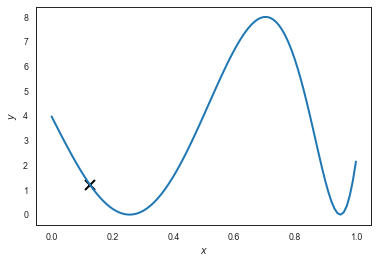

In [8]:
def f(x):
    return 4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

np.random.seed(123456) # For reproducibility
n_init = 1
X = np.random.rand(n_init) # In 1D you don't have to use LHS
Y = f(X)
plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
x = np.linspace(0, 1, 100)
plt.plot(x, f(x), linewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$');

Just like in the previous hands-on activity, assume that we have made some observations and that we have used them to do Gaussian process regression resulting in the point-predictive distribution:
$$
p(y|\mathbf{x},\mathcal{D}_{n}) = \mathcal{N}\left(y|m_{n}(\mathbf{x}), \sigma^2_{n}(\mathbf{x})\right),
$$
where $m_{n}(\mathbf{x})$ and $\sigma^2_{n}(\mathbf{x})$ are the predictive mean and variance respectively.
Here is the code for this:

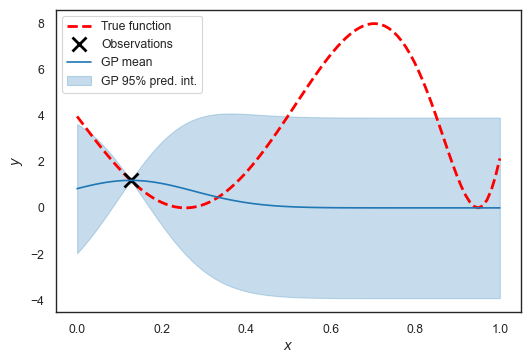

In [9]:
import GPy
# The kernel we use
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
# Assuming that we know there is no measurement noise:
gpr.likelihood.variance.constrain_fixed(1e-16)
# You can evaluate the predictive distribution anywhere:
m, sigma2 = gpr.predict(x[:, None])
# And you can visualize the results as follows
# Standard deviation
sigma = np.sqrt(sigma2)
# Lower quantile
l = m - 1.96 * sigma
u = m + 1.96 * sigma
fig, ax = plt.subplots(dpi=100)
plt.plot(x, f(x), 'r--', linewidth=2, label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='Observations')
ax.plot(x, m, label='GP mean')
ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25,
                label='GP 95% pred. int.')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

Imagine that you have observed data $\mathcal{D}_n$.
How certain are you about the location of the maximum?
If $n$ is small, you can't be too confident?
How do you quantify this epistemic uncertainty?
Notice that the maximum and the location of the maximum are *operators* acting on $f$:
$$
f^* := \max[f] := \max_{\mathbf{x}} f(\mathbf{x}),
$$
and
$$
\mathbf{x}^* := \mathbf{X}^*[f] := \arg\max_{\mathbf{x}} f(\mathbf{x}),
$$
respectively.
So since, we are uncertain about $f$, we will be uncertain about $f^*$ and $\mathbf{x}^*$.
In particular, we would like to somehow quantify the joint probability density $p(\mathbf{x}^*, f^*|\mathcal{D}_n)$.
Here is what is the formal answer:
$$
p(\mathbf{x}^*, f^*|\mathcal{D}_n) = \int \delta(\mathbf{x}^* - \mathbf{X}^*[f])\delta(f^*-\max[f])p(f(\cdot)|\mathcal{D}_n)df(\cdot).
$$
Of course, this is not technically correct because you cannot integrate over a function in this way.
The correct way to write this mathematically is to use conditional expectations:
$$
p(\mathbf{x}^*, f^*|\mathcal{D}_n) = \mathbb{E}\left[\delta(\mathbf{x}^* - \mathbf{X}^*[f])\delta(f^*-\max[f])|\mathcal{D}_n\right],
$$
where the expectation is taken over $f(\cdot)$ conditional on $\mathcal{D}_n$.
In any case, there are two questions:
+ What does this actually mean?
+ How do you compute it?

First, what does it actually mean?
To understand this you need to pay attention to the delta function.
Take for example $\delta(f^* - \max[f])$. What does it do?
Well, it just hits a counter whenever $\max[f]$ matches $f^*$ exactly as you take the expectation over $f(\cdot)$.

Second, how do you compute it?
The simplest way to do this is through sampling.
You basically just sample functions from $p(f(\cdot)|\mathcal{D}_n)$ and you find their maximum the location of the maximum.
Of course, you cannot really sample a function.
You sample the *function values* at a finite, but dense, number of input points and you find the maximum amongst these points.
Once you get these samples, you just look at their histogram.

Ok, let's do it for our working example:

In [10]:
def plot_max_and_argmax(gpr, X_design, n_samples=1000):
    """
    Plots histograms of the max and argmax of the function represented by the model gpr.
    It takes ``n_samples`` samples from the posterior to do that evaluated at ``X_design``.
    """
    f_samples = gpr.posterior_samples_f(X_design, size=n_samples)[:, 0, :]
    max_f_samples = np.max(f_samples, axis=0)
    x_star_samples = X_design[np.argmax(f_samples, axis=0), 0]
    fig, ax = plt.subplots(dpi=100)
    ax.hist(max_f_samples, density=True, alpha=0.25)
    ax.set_xlabel('$f^*$')
    ax.set_ylabel('$p(f^*|\mathcal{D}_n)$')
    fig, ax = plt.subplots(dpi=100)
    ax.hist(x_star_samples, density=True, alpha=0.25)
    ax.set_xlabel('$x^*$')
    ax.set_ylabel('$p(x^*|\mathcal{D}_n)$')
    return fig, ax

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='$x^*$', ylabel='$p(x^*|\\mathcal{D}_n)$'>)

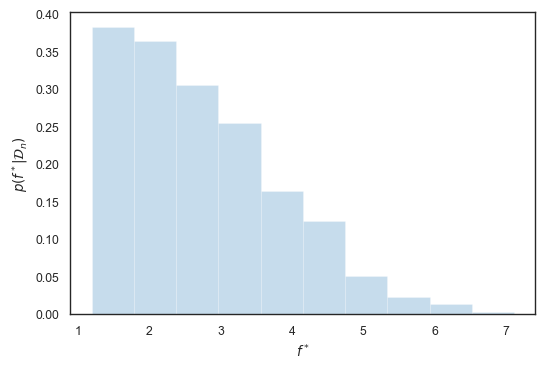

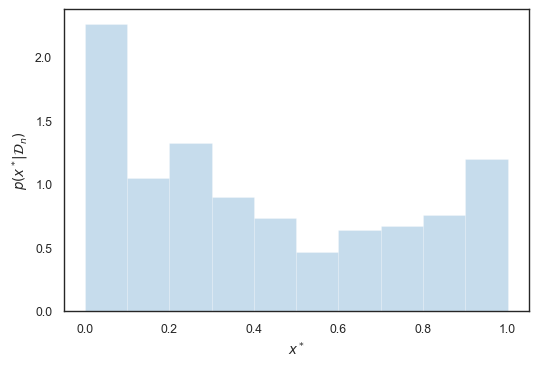

In [11]:
plot_max_and_argmax(gpr, x[:, None])

Let's put this functionality to our maximization algorithm:

In [12]:
def mui(m, sigma, ymax, psi=1.96):
    """
    Return the maximum upper interval.
    """
    return m + psi * sigma

def poi(m, sigma, ymax, psi=0.):
    """
    Return the probability of improvement.
    """
    return st.norm.cdf((m - ymax - psi) / sigma)

def ei(m, sigma, ymax, psi=0.):
    """
    Return the expected improvement.
    """
    u = (m - ymax) / sigma
    ei = sigma * (u * st.norm.cdf(u) + st.norm.pdf(u))
    ei[sigma <= 0.] = 0.
    return ei

def maximize(f, gpr, X_design, alpha, psi=0., max_it=6, plot_epistemic=True):
    """
    Optimize f using a limited number of evaluations.
    
    :param f:        The function to optimize.
    :param gpr:      A Gaussian process model to use for representing our state of knowldege.
    :param X_design: The set of candidate points for identifying the maximum.
    :param alpha:    The acquisition function.
    :param psi:      The parameter value for the acquisition function (not used for EI).
    :param max_it:   The maximum number of iterations.
    """
    af_all = []
    for count in range(max_it):
        m, sigma2 = gpr.predict(X_design)
        sigma = np.sqrt(sigma2)
        l = m - 1.96 * sigma
        u = m + 1.96 * sigma
        af_values = alpha(m, sigma, gpr.Y.max(), psi=psi)
        i = np.argmax(af_values)
        X = np.vstack([gpr.X, X_design[i:(i+1), :]])
        y = np.vstack([gpr.Y, [f(X_design[i, :])]])
        gpr.set_XY(X, y)
        # Uncomment the following to optimize the hyper-parameters
        # gpr.optimize()
        af_all.append(af_values[i])
        fig, ax = plt.subplots(dpi=100)
        ax.set_title('BGO Iteration #{0:d}'.format(count+1))
        ax.plot(gpr.X, gpr.Y, 'kx', markersize=10, markeredgewidth=2)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.plot(x, m)
        ax.fill_between(X_design.flatten(), l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
        ax2 = ax.twinx()
        ax2.plot(X_design, af_values, color=sns.color_palette()[1])
        plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
        ax2.set_ylabel('acquisition function', color=sns.color_palette()[1])
        ax2.plot(X_design[i, :] * np.ones(100), np.linspace(0, af_values[i], 100), color=sns.color_palette()[1],
                 linewidth=1)
        if plot_epistemic:
            fig, ax = plot_max_and_argmax(gpr, X_design)
            ax.set_title('BGO Iteration #{0:d}'.format(count+1))
    return af_all

And here is a complete run of the lagorithm.

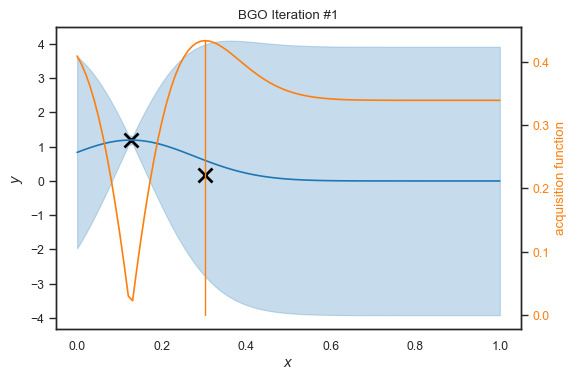

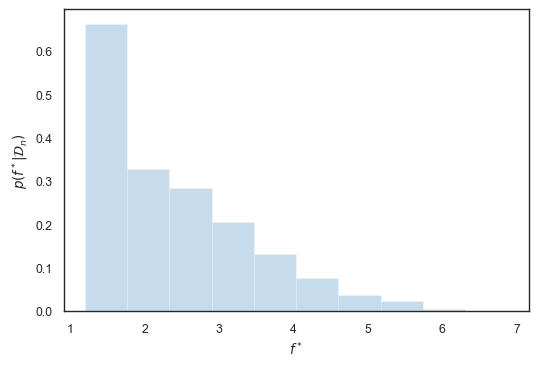

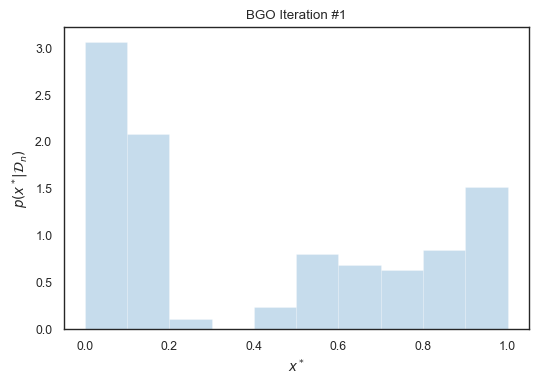

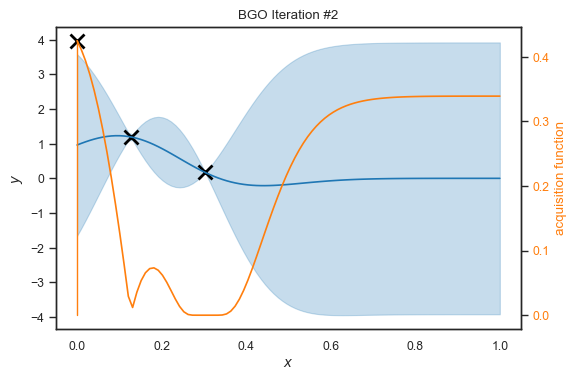

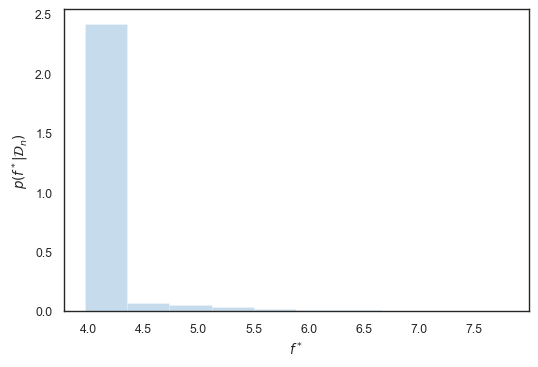

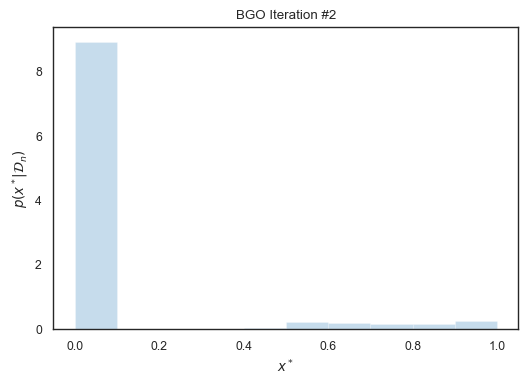

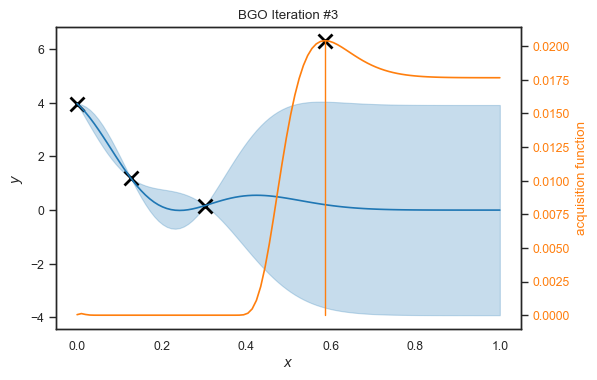

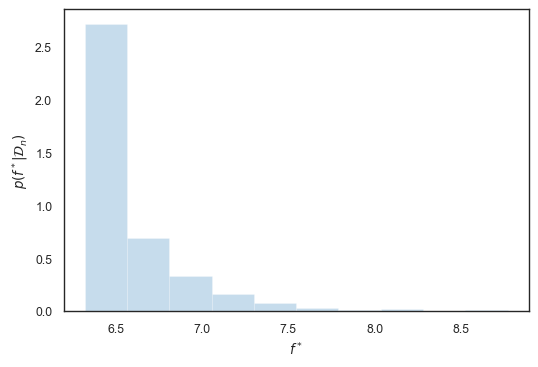

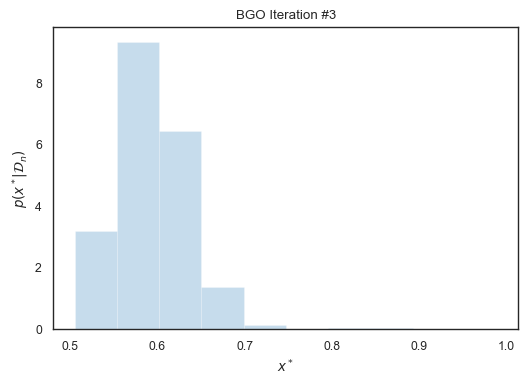

In [13]:
# Prepare the initial statistical model
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
gpr.likelihood.variance.constrain_fixed(1e-16)

# Run the algorithm
af_all = maximize(f, gpr, x[:, None], alpha=ei, psi=0., max_it=3)

### Questions
+ How does the epistemic uncertainty about the optimization problem change when you decrease the number of initial samples?

+ Try changing the number of initial samples to a very small number? Does the algorithm work?